In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [89]:
import matplotlib.pyplot as pl
from matplotlib.colors import LogNorm
from matplotlib import rcParams
import numpy as np
import scipy.ndimage as nd
import tables
from scipy.stats import scoreatpercentile
import os

from src import this_project as P
from src import core as cr

In [3]:
params = {
    'backend': 'pdf',
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'font.size': 8,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'font.family': 'serif',
    'figure.dpi': 300,
    'image.cmap': 'viridis'
}

rcParams.update(params)

# Load data

### HI data

In [4]:
with tables.open_file(os.path.join(P.BASEPATH, 'survey2pytable/data/HI4PI.h5')) as hi_store:
    nhi = hi_store.root.mom0[:,0]

/Users/dlenz/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


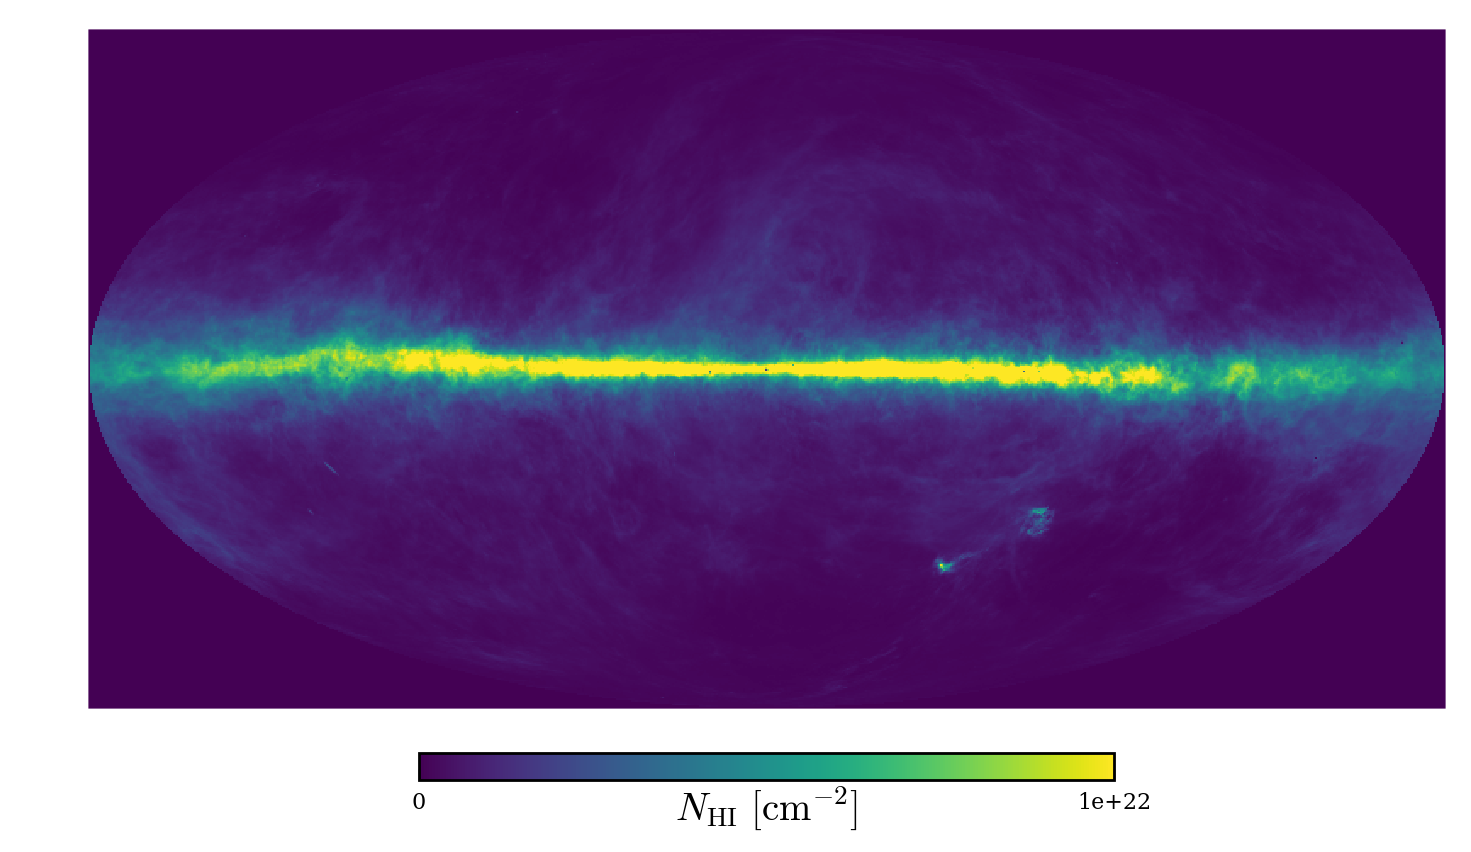

In [5]:
fig = pl.figure(figsize=P.FIGSIZE_2COL, num=1)
hp.mollview(nhi, cmap='viridis', min=0., max=1.e22, fig=1, title='', unit=r'$N_{\rm HI}\ [\rm cm^{-2}]$')

### Gaussian decomposition

In [6]:
store = tables.open_file(os.path.join(P.PROJECTPATH, 'data/HI4PI_Aug25.h5'))
table = store.root.gaussdec

In [7]:
table.dtype

dtype([('amplitude', '<f4'), ('center_c', '<f4'), ('center_kms', '<f4'), ('glat', '<f4'), ('glon', '<f4'), ('hpxindex', '<i4'), ('sigma_c', '<f4'), ('sigma_kms', '<f4')])

In [8]:
amps = table.cols.amplitude[:]
v_centre = table.cols.center_kms[:]
sigmas = table.cols.sigma_kms[:]

In [9]:
fwhms_kms = sigmas * 2.355
n_hi = amps * 1.82e18 * 1.288

#### GP mask

In [10]:
phi, theta = hp.pix2ang(P.NSIDE, np.arange(P.NPIX))
glon = np.degrees(phi)
glat = 90. - np.degrees(phi)
gp_mask = np.abs(glat) > 20.

#### Mask negative continuum sources

In [36]:
cont_mask = nhi > 0.

### Extract model values and its fitted parameters

In [11]:
model = cr.reconstruct_coldens(table)

/Users/dlenz/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


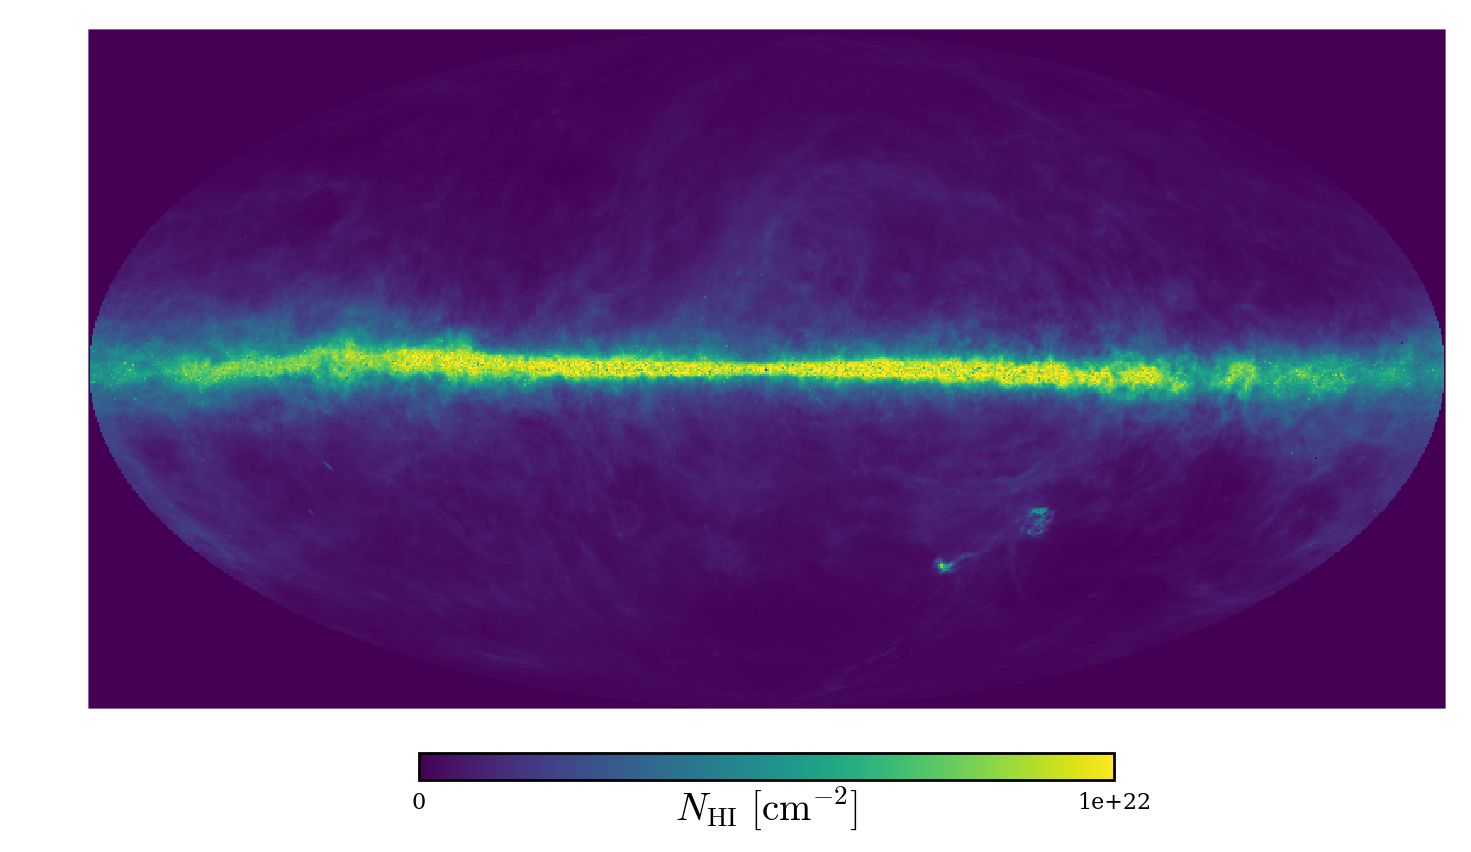

In [12]:
fig = pl.figure(figsize=P.FIGSIZE_2COL, num=1)
hp.mollview(model, cmap='viridis', min=0., max=1.e22, fig=1, title='', unit=r'$N_{\rm HI}\ [\rm cm^{-2}]$')

### Residual

In [13]:
residual = nhi - model

/Users/dlenz/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


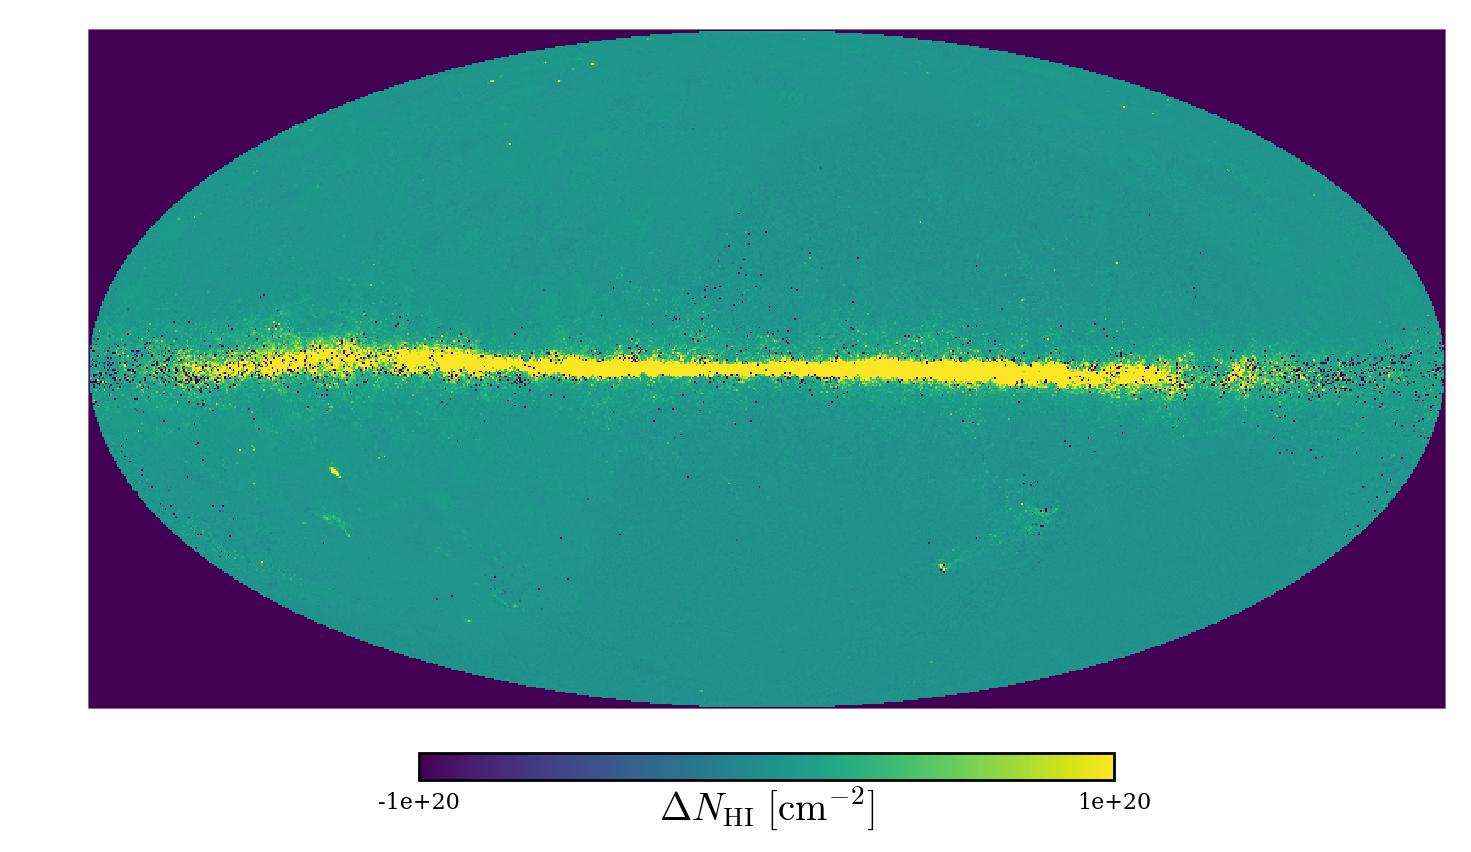

In [14]:
fig = pl.figure(figsize=P.FIGSIZE_2COL, num=1)
hp.mollview(residual, cmap='viridis', min=-1e20, max=1.e20, fig=1, title='', unit=r'$\Delta N_{\rm HI}\ [\rm cm^{-2}]$')

/Users/dlenz/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/dlenz/anaconda/lib/python3.5/site-packages/healpy/pixelfunc.py:270: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/dlenz/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:2255: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/dlenz/anaconda/lib/python3.5/site-packages/healpy/projaxes.py:998: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/dlenz/anaconda/lib/python3.5/site-packages/healpy/projaxes.py:999: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


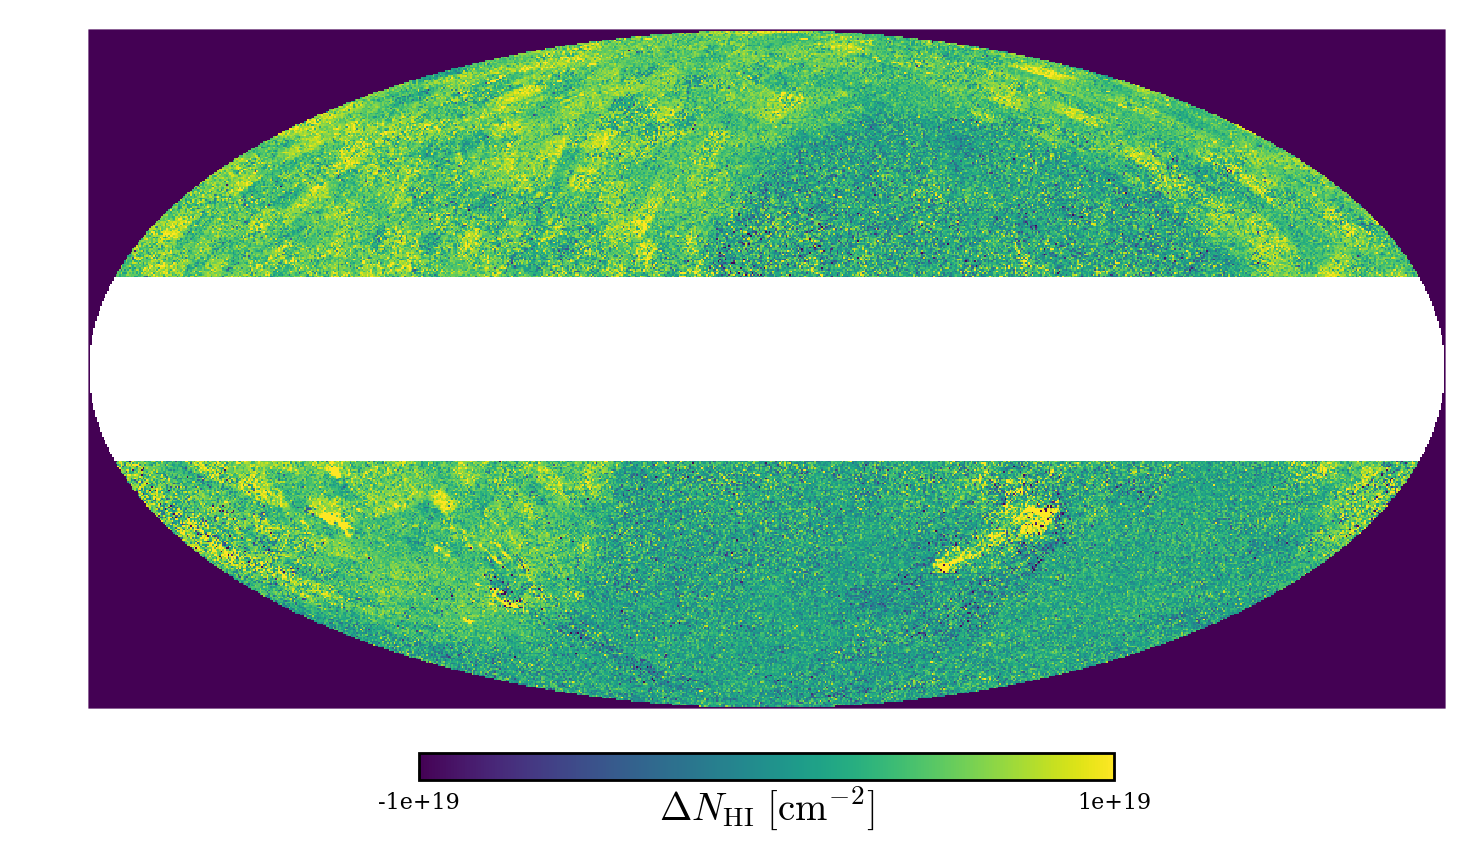

In [15]:
fig = pl.figure(figsize=P.FIGSIZE_2COL, num=1)
hp.mollview(np.where(gp_mask, residual, np.nan), cmap='viridis', min=-1e19, max=1.e19, fig=1, title='', unit=r'$\Delta N_{\rm HI}\ [\rm cm^{-2}]$')

### Scatterplot data vs. model

In [119]:
x_data = nhi[cont_mask & gp_mask][::10]
y_data = residual[cont_mask & gp_mask][::10]

In [120]:
p_opt = np.polyfit(x_data, y_data, deg=1)
xm = np.linspace(3.e19, 2.e21, 1000)
ym = np.polyval(p_opt, xm)

/Users/dlenz/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


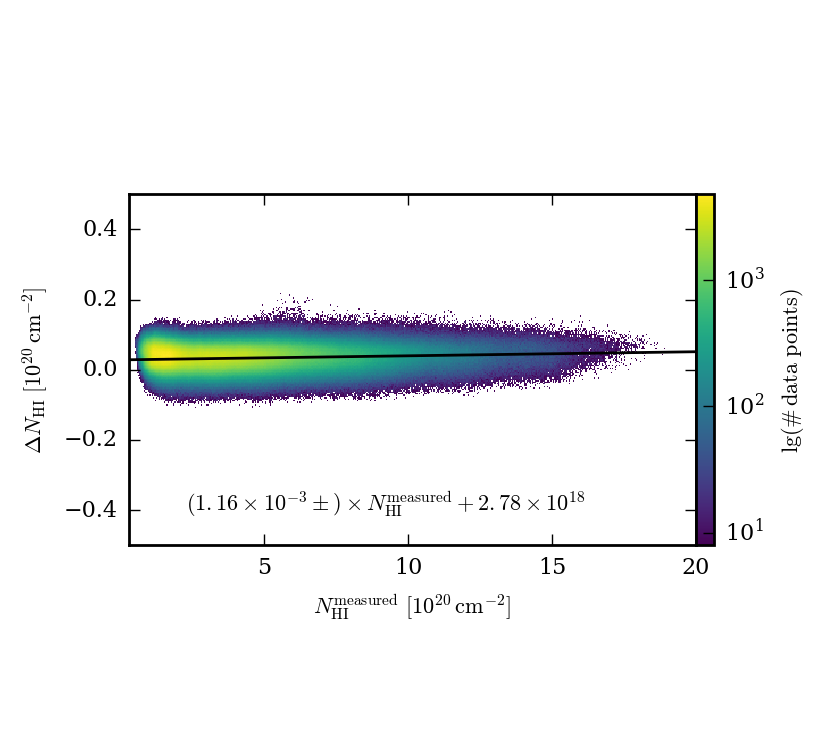

In [134]:
fig = pl.figure(figsize=P.FIGSIZE_1COL)
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
cax = fig.add_axes((0.9, 0.1, 0.025, 0.8))
hist_range = [[3.e-1, 2.e1], [-1., 1.]]
*_, im = ax.hist2d(nhi[cont_mask & gp_mask]/1.e20, residual[cont_mask & gp_mask]/1.e20,
              bins=500,
              range=hist_range,
              cmin=8,
              norm=LogNorm())
ax.plot(xm/1.e20, ym/1.e20, c='k', linestyle='-', linewidth=1)

# colorbar
cbar = pl.colorbar(im, cax=cax)
cbar.set_label(r'$\rm lg(\#\, data\ points)$')

# limits
ax.set_xlim([3.e-1, 2.e1])
ax.set_ylim([-5e-1, 5e-1])

# labels
ax.set_xlabel(r'$N_{\rm HI}^{\rm measured}\ [10^{20}\,\rm cm^{-2}]$')
ax.set_ylabel(r'$\Delta N_{\rm HI}\ [10^{20}\,\rm cm^{-2}]$')

# textbox with fit params
s = r'$(1.16\times 10^{-3}\pm)\times N_{{\rm HI}}^{{\rm measured}} + {2.78\times 10^{18}}$'
ax.text(0.1, 0.1, s, transform=ax.transAxes)

In [122]:
p_opt

array([  1.16323696e-03,   2.78216871e+18])

### Number of components

In [16]:
# n_comps = np.load('data/n_comps.npy')

In [17]:
n_comps = cr.make_ncomp_map(table)

/Users/dlenz/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


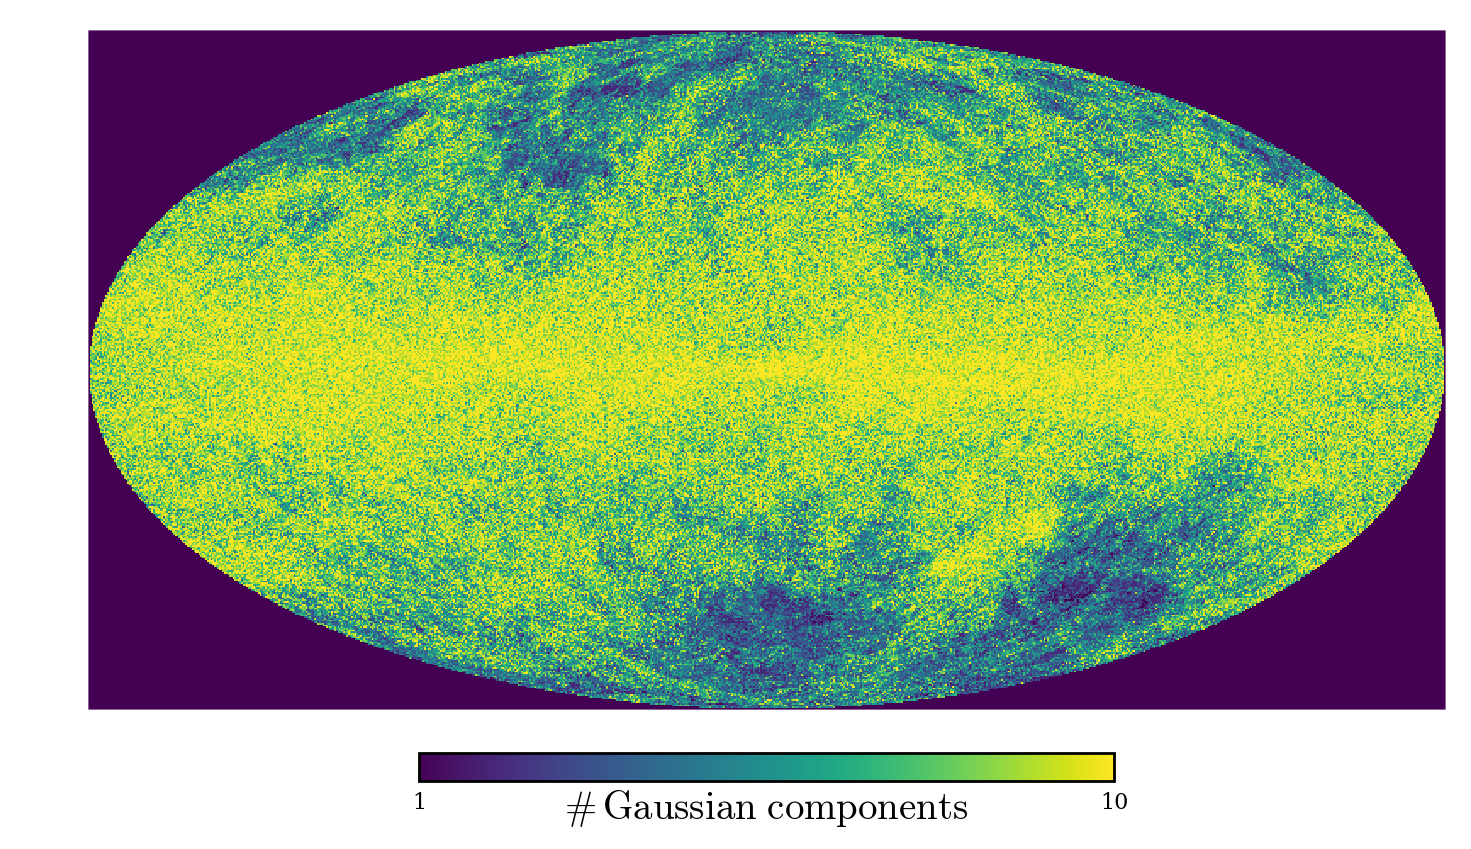

In [18]:
fig = pl.figure(figsize=P.FIGSIZE_2COL, num=1)
hp.mollview(n_comps, cmap='viridis', fig=1, title='', unit=r'$\#\,\rm Gaussian\ components$')

## Generate 2D histograms

### $v_{center}\ vs.\ \sigma$

In [26]:
centre_sigma_params = np.histogram2d(v_centre, np.log10(fwhms_kms),
              bins=200,
              range=[[-600., 600.],[0.2, 1.25]])

/Users/dlenz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


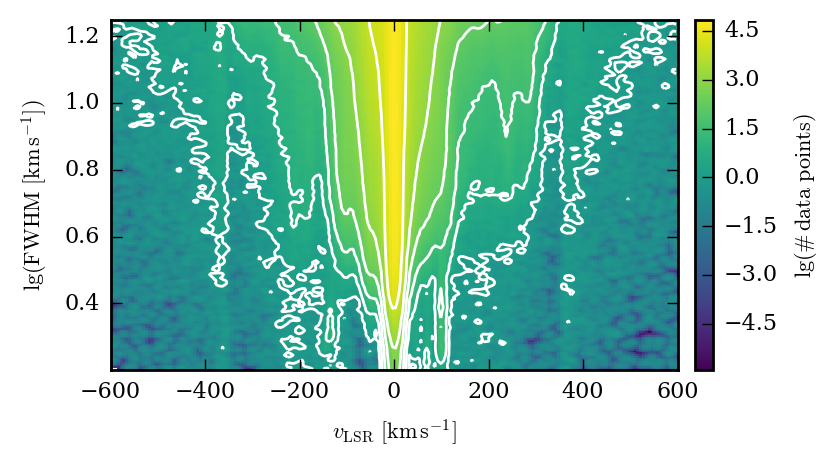

In [27]:
def plot_centre_sigma(params):
    counts, xbins, ybins = params
    fig = pl.figure(figsize=P.FIGSIZE_1COL)
    ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
    cax = fig.add_axes((0.925, 0.1, 0.025, 0.8))
    
    # smooth counts
    counts_sm = nd.gaussian_filter(counts.T, sigma=1.)
    
    im = ax.imshow(np.log10(counts_sm),
        extent=[xbins.min(), xbins.max(),ybins.min(),ybins.max()],
        origin='lower',
        aspect='auto',
        cmap='viridis',
        interpolation='nearest')

    cbar = pl.colorbar(im, cax=cax)
    cbar.set_label(r'$\rm lg(\#\, data\ points)$')

    ax.contour(
        counts_sm,
        extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
        levels=P.CONTLEVELS,
        origin='lower',
        colors='w',
        linewidth=1)

    ax.set_xlabel(r'$v_{\rm LSR}\ [\rm km\,s^{-1}]$')
    ax.set_ylabel(r'$\rm lg(FWHM\ [\rm km\,s^{-1}])$')

plot_centre_sigma(centre_sigma_params)

### $N_{\rm HI}\ vs.\
\sigma$

In [21]:
nhi_sigma_params = np.histogram2d(np.log10(n_hi), np.log10(fwhms_kms),
              bins=200,
              range=[[18.5, 21.2],[0.2, 1.25]])

/Users/dlenz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


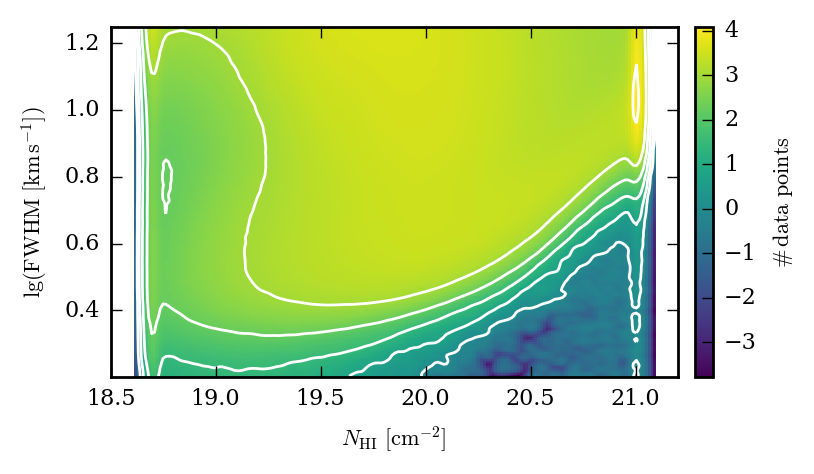

In [22]:
def plot_nhi_sigma(params):
    counts, xbins, ybins = params
    fig = pl.figure(figsize=P.FIGSIZE_1COL)
    ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
    cax = fig.add_axes((0.925, 0.1, 0.025, 0.8))
    
    # smooth counts
    counts_sm = nd.gaussian_filter(counts.T, sigma=1.5)
    
    im = ax.imshow(np.log10(counts_sm),
        extent=[xbins.min(), xbins.max(),ybins.min(),ybins.max()],
        origin='lower',
        aspect='auto',
        cmap='viridis',
        interpolation='nearest')

    cbar = pl.colorbar(im, cax=cax)
    cbar.set_label(r'$\#\,\rm data\ points$')

    ax.contour(
        counts_sm,
        extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
        levels=P.CONTLEVELS,
        origin='lower',
        colors='w')

    ax.set_xlabel(r'$N_{\rm HI}\ [\rm cm^{-2}]$')
    ax.set_ylabel(r'$\rm lg(FWHM\ [\rm km\,s^{-1}])$')

plot_nhi_sigma(nhi_sigma_params)